In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns

In [2]:
plt.style.use("~/nice.mplstyle")

In [3]:
nice_names = {
    "sp": "Surface Pressure",
    "u10": "10m Zonal Wind",
    "v10": "10m Meridional Wind",
    "t2m": "2m Temperature",
    "sh2": "2m Specific Humidity",
    "gh": "Geopotential Height",
    "u": "Zonal Wind",
    "v": "Meridional Wind",
    "w": "Vertical Velocity",
    "t": "Temperature",
    "q": "Specific Humidity",
}

In [4]:
def single_plot(ax, dsdict, varname, sel=None, **kwargs):
    xticks = None
    for label, xds in dsdict.items():
        
        plotme = xds[varname] if sel is None else xds[varname].sel(**sel)
        if xticks is None:
            xticks = plotme.fhr.values
        df = plotme.to_dataframe().reset_index()
        if label == "HRRR":
            color="gray"
        elif label == "THRRR":
            color="black"
        elif label == "Deterministic":
            color = "C0"
        elif label == "Ensemble Mean":
            color = "C3"
        else:
            color=None
        sns.lineplot(
            data=df,
            x="fhr",
            y=varname,
            ax=ax,
            label=label,
            color=color,
            alpha=.4 if "member" in xds.dims else None,
            **kwargs,
        )
    xticks = xticks if len(xticks)<10 else np.concatenate([ [xticks[0]], xticks[4::4]])
    ax.set(
        ylabel=metric.upper() if ax.get_subplotspec().is_first_col() else "",
        xlabel="Forecast Hour" if ax.get_subplotspec().is_last_row() else "",
        title=nice_names[varname] if ax.get_subplotspec().is_first_row() else "",
        xticks=xticks,
    )
    ax.legend(frameon=False)

In [5]:
def plot_surface_error(surface_vars, dsdict, model_filter=None, **kwargs):
    ncols = len(surface_vars)
    fig, axs = plt.subplots(1, ncols, figsize=(5*ncols, 4), constrained_layout=True)

    if len(surface_vars) == 1:
        axs = [axs]
    for varname, ax in zip(surface_vars, axs):
        single_plot(ax=ax, dsdict=dsdict, varname=varname, **kwargs)
    return fig, axs

In [6]:
def plot_level_vars(level_vars, dsdict, **kwargs):
    
    levels = next(iter(dsdict.values())).level.values
    ncols = len(level_vars)
    nrows = len(levels)
    fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4.5*nrows), constrained_layout=True)

    if len(levels) == 1:
        axs = [axs]
    if len(level_vars) == 1:
        axs = [axs]

    sel = kwargs.pop("sel", {})
    for level, axr in zip(levels, axs):
        for varname, ax in zip(level_vars, axr):
            
            sel["level"] = level
            single_plot(ax=ax, dsdict=dsdict, varname=varname, sel=sel, **kwargs)
            ax.legend(title=f"{level} hPa", frameon=False)
    return fig, axs

## Plots

In [7]:
metric = "rmse"
base = {
    "mse06h": xr.load_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/latent-updates/fixed/inference-validation/{metric}.nested-lam.nc", decode_timedelta=False),
    "mlpnoise32": xr.load_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/crps06h/experiments/base/mlpnoise32/inference-validation/{metric}_ensmean.nested-lam.nc", decode_timedelta=False),
    "steps060k": xr.load_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/crps06h/experiments/training-steps/steps060k/inference-validation/{metric}_ensmean.nested-lam.nc", decode_timedelta=False),
}
    
base["HRRR"] = xr.load_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/baselines/hrrr-forecasts-vs-hrrr-analysis/trim10/{metric}.lam.nc", decode_timedelta=True)

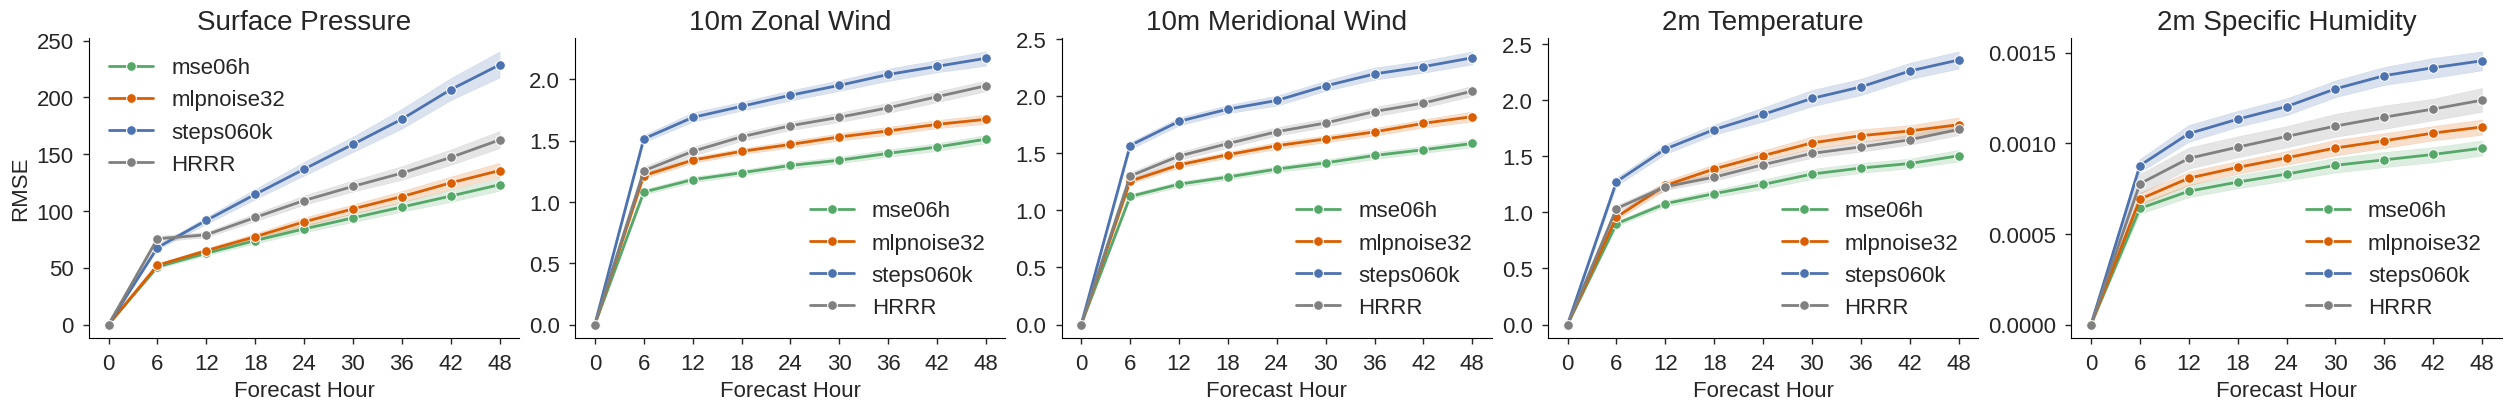

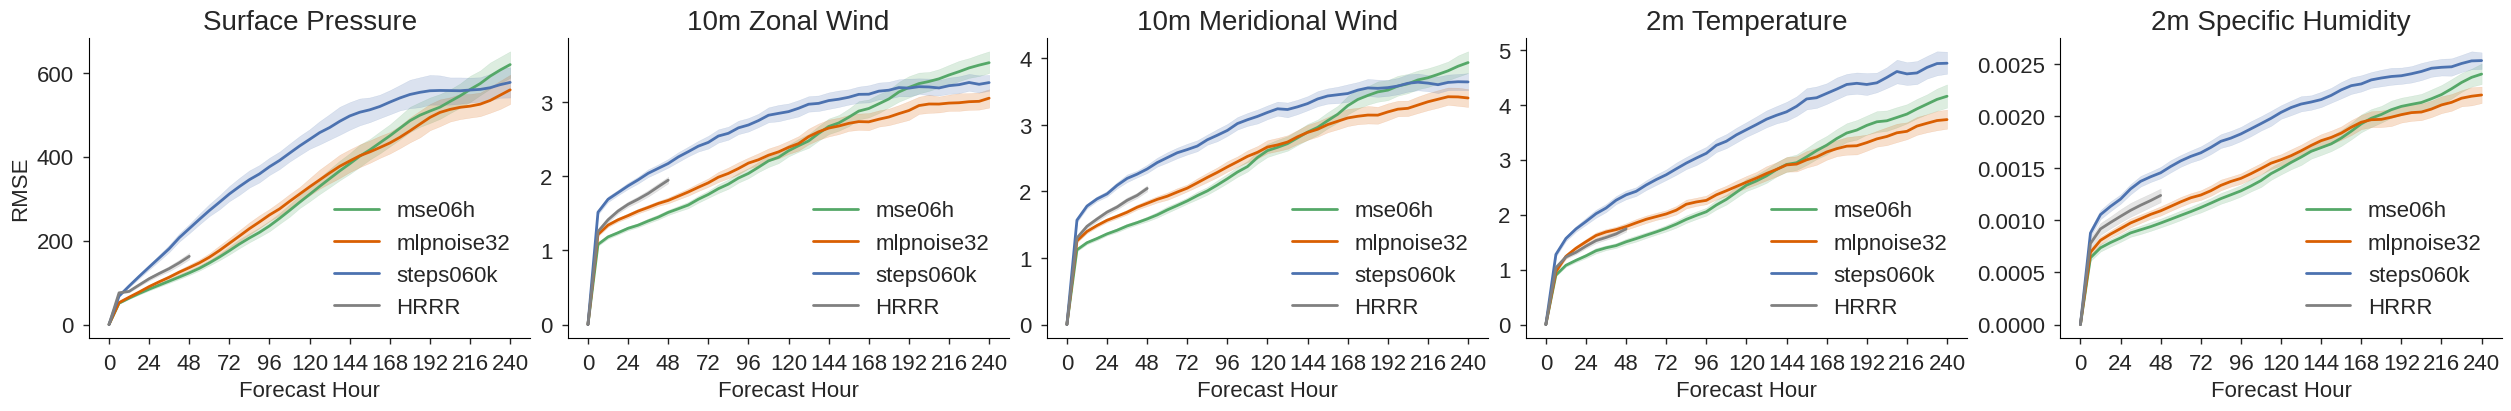

In [8]:
for name, kwargs in zip(["48h", "10d"], [{"sel": {"fhr": slice(49)}, "marker": "o"}, {}]):
    fig, axs = plot_surface_error(
        ["sp", "u10", "v10", "t2m", "sh2"],
        dsdict=base,
        **kwargs,
    )
    fname = f"figures/surface_{metric}_vs_hrrr_analysis_{name}.jpeg"
    fig.savefig(fname, dpi=300, bbox_inches="tight")

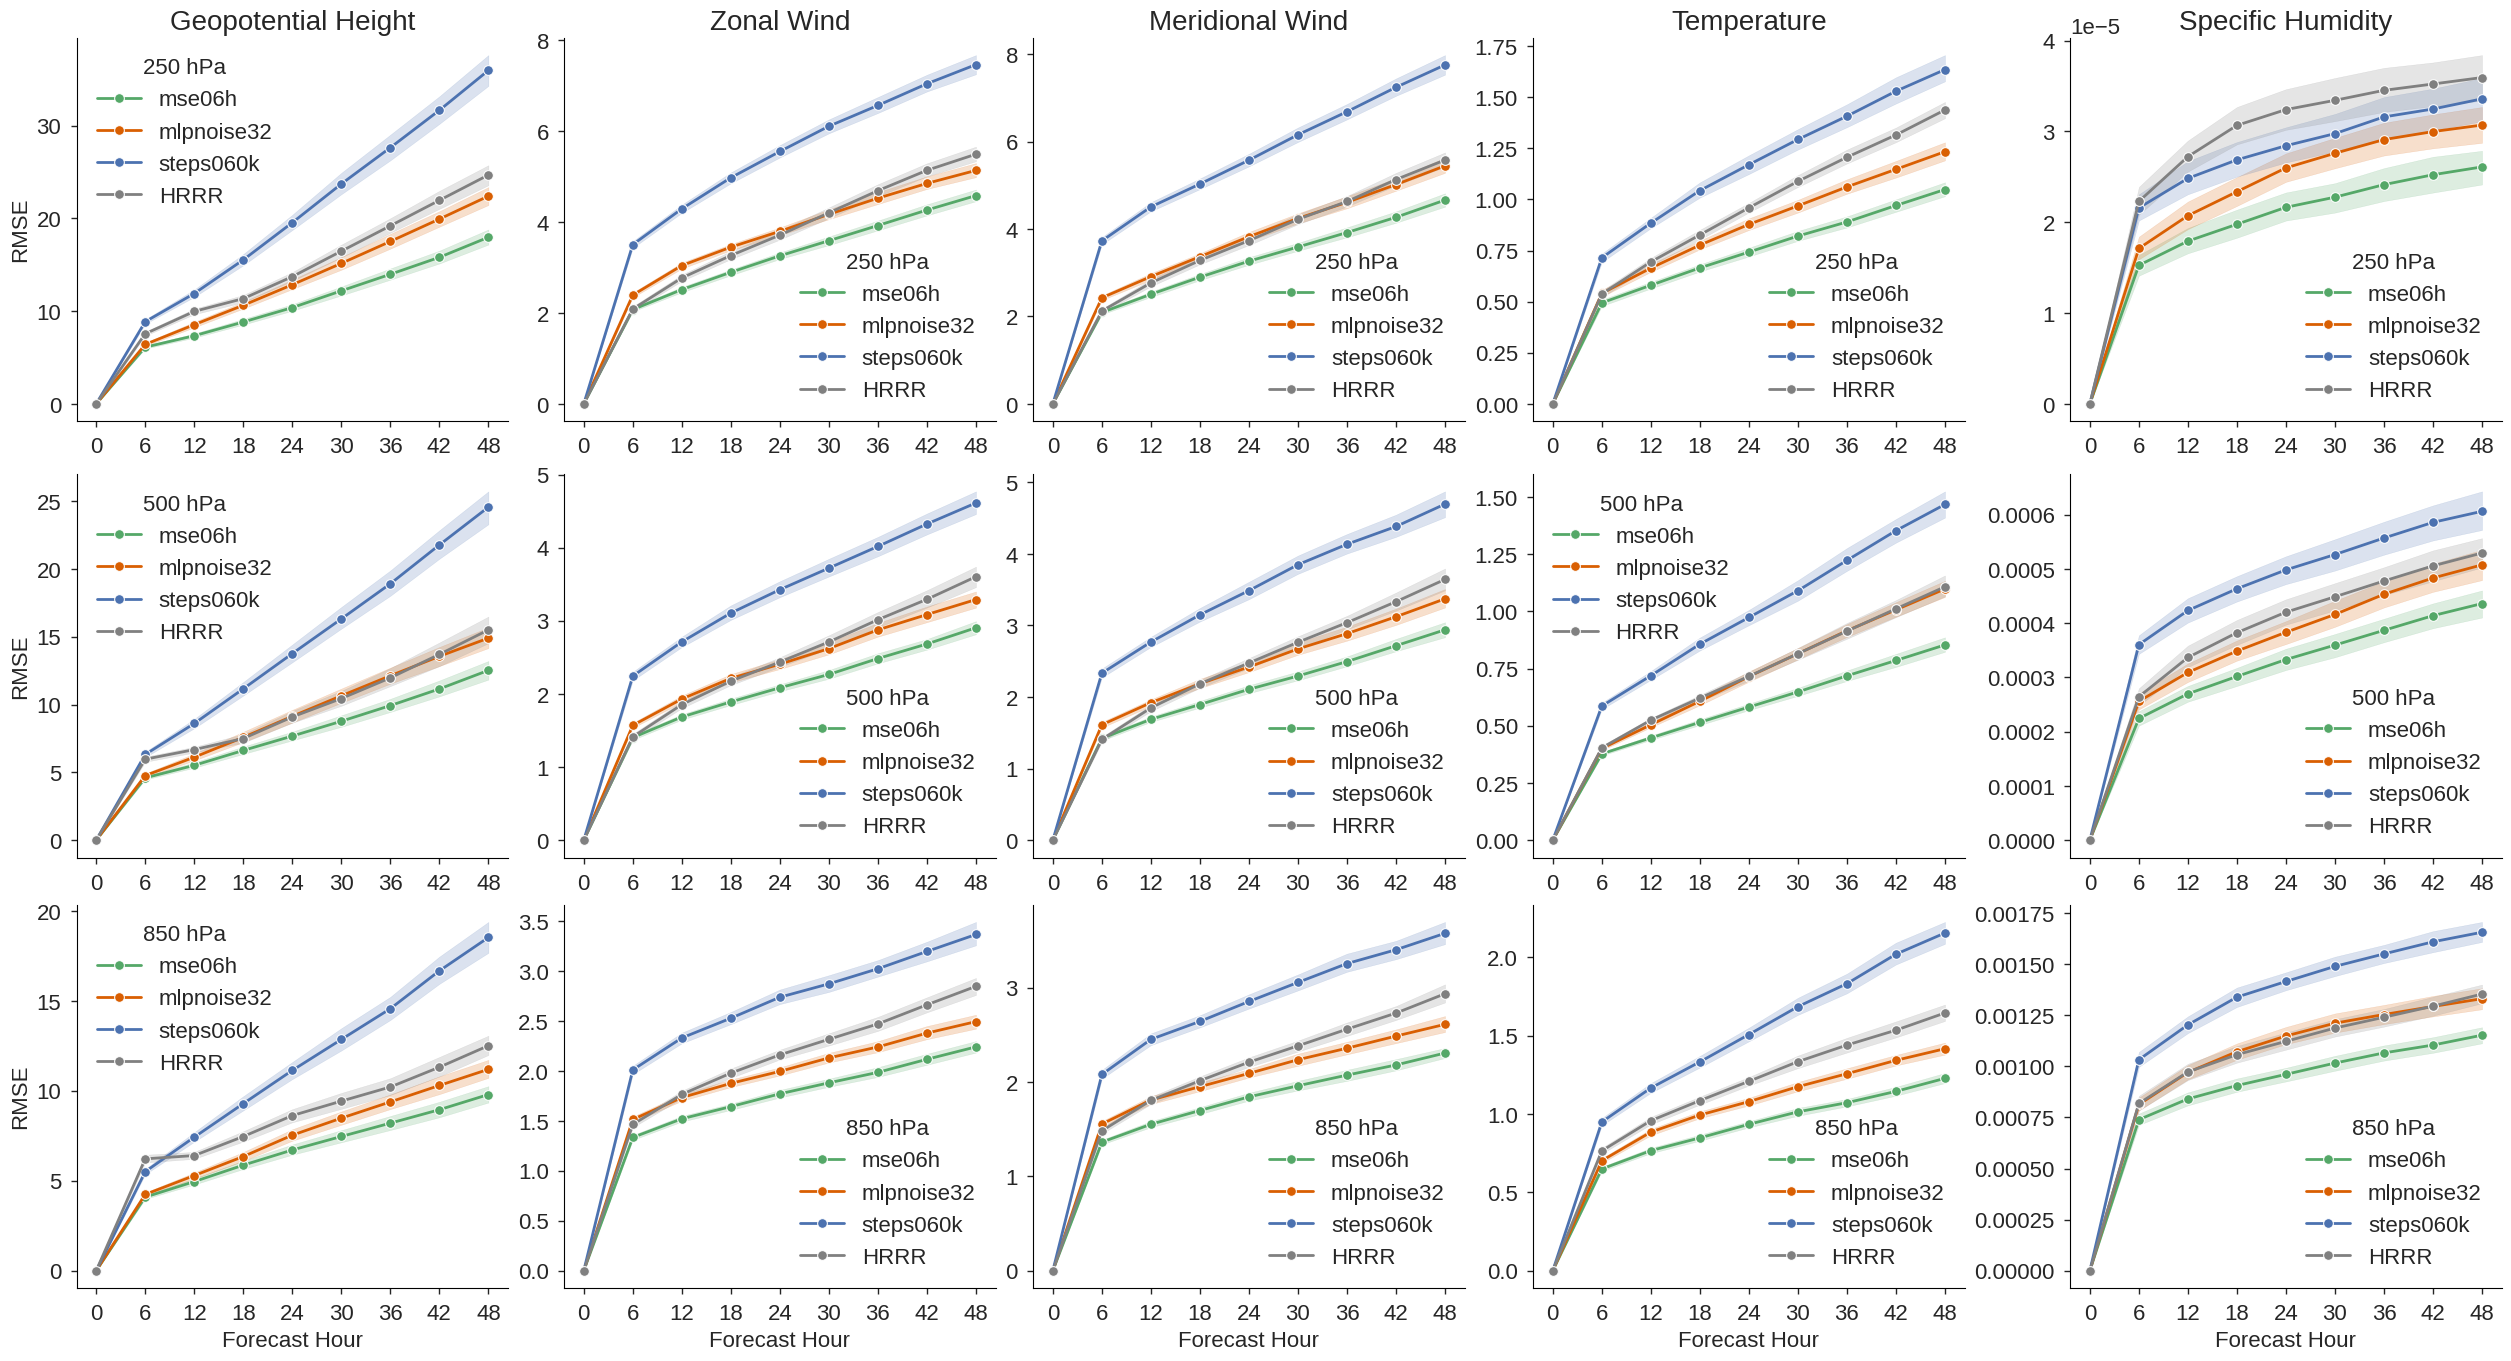

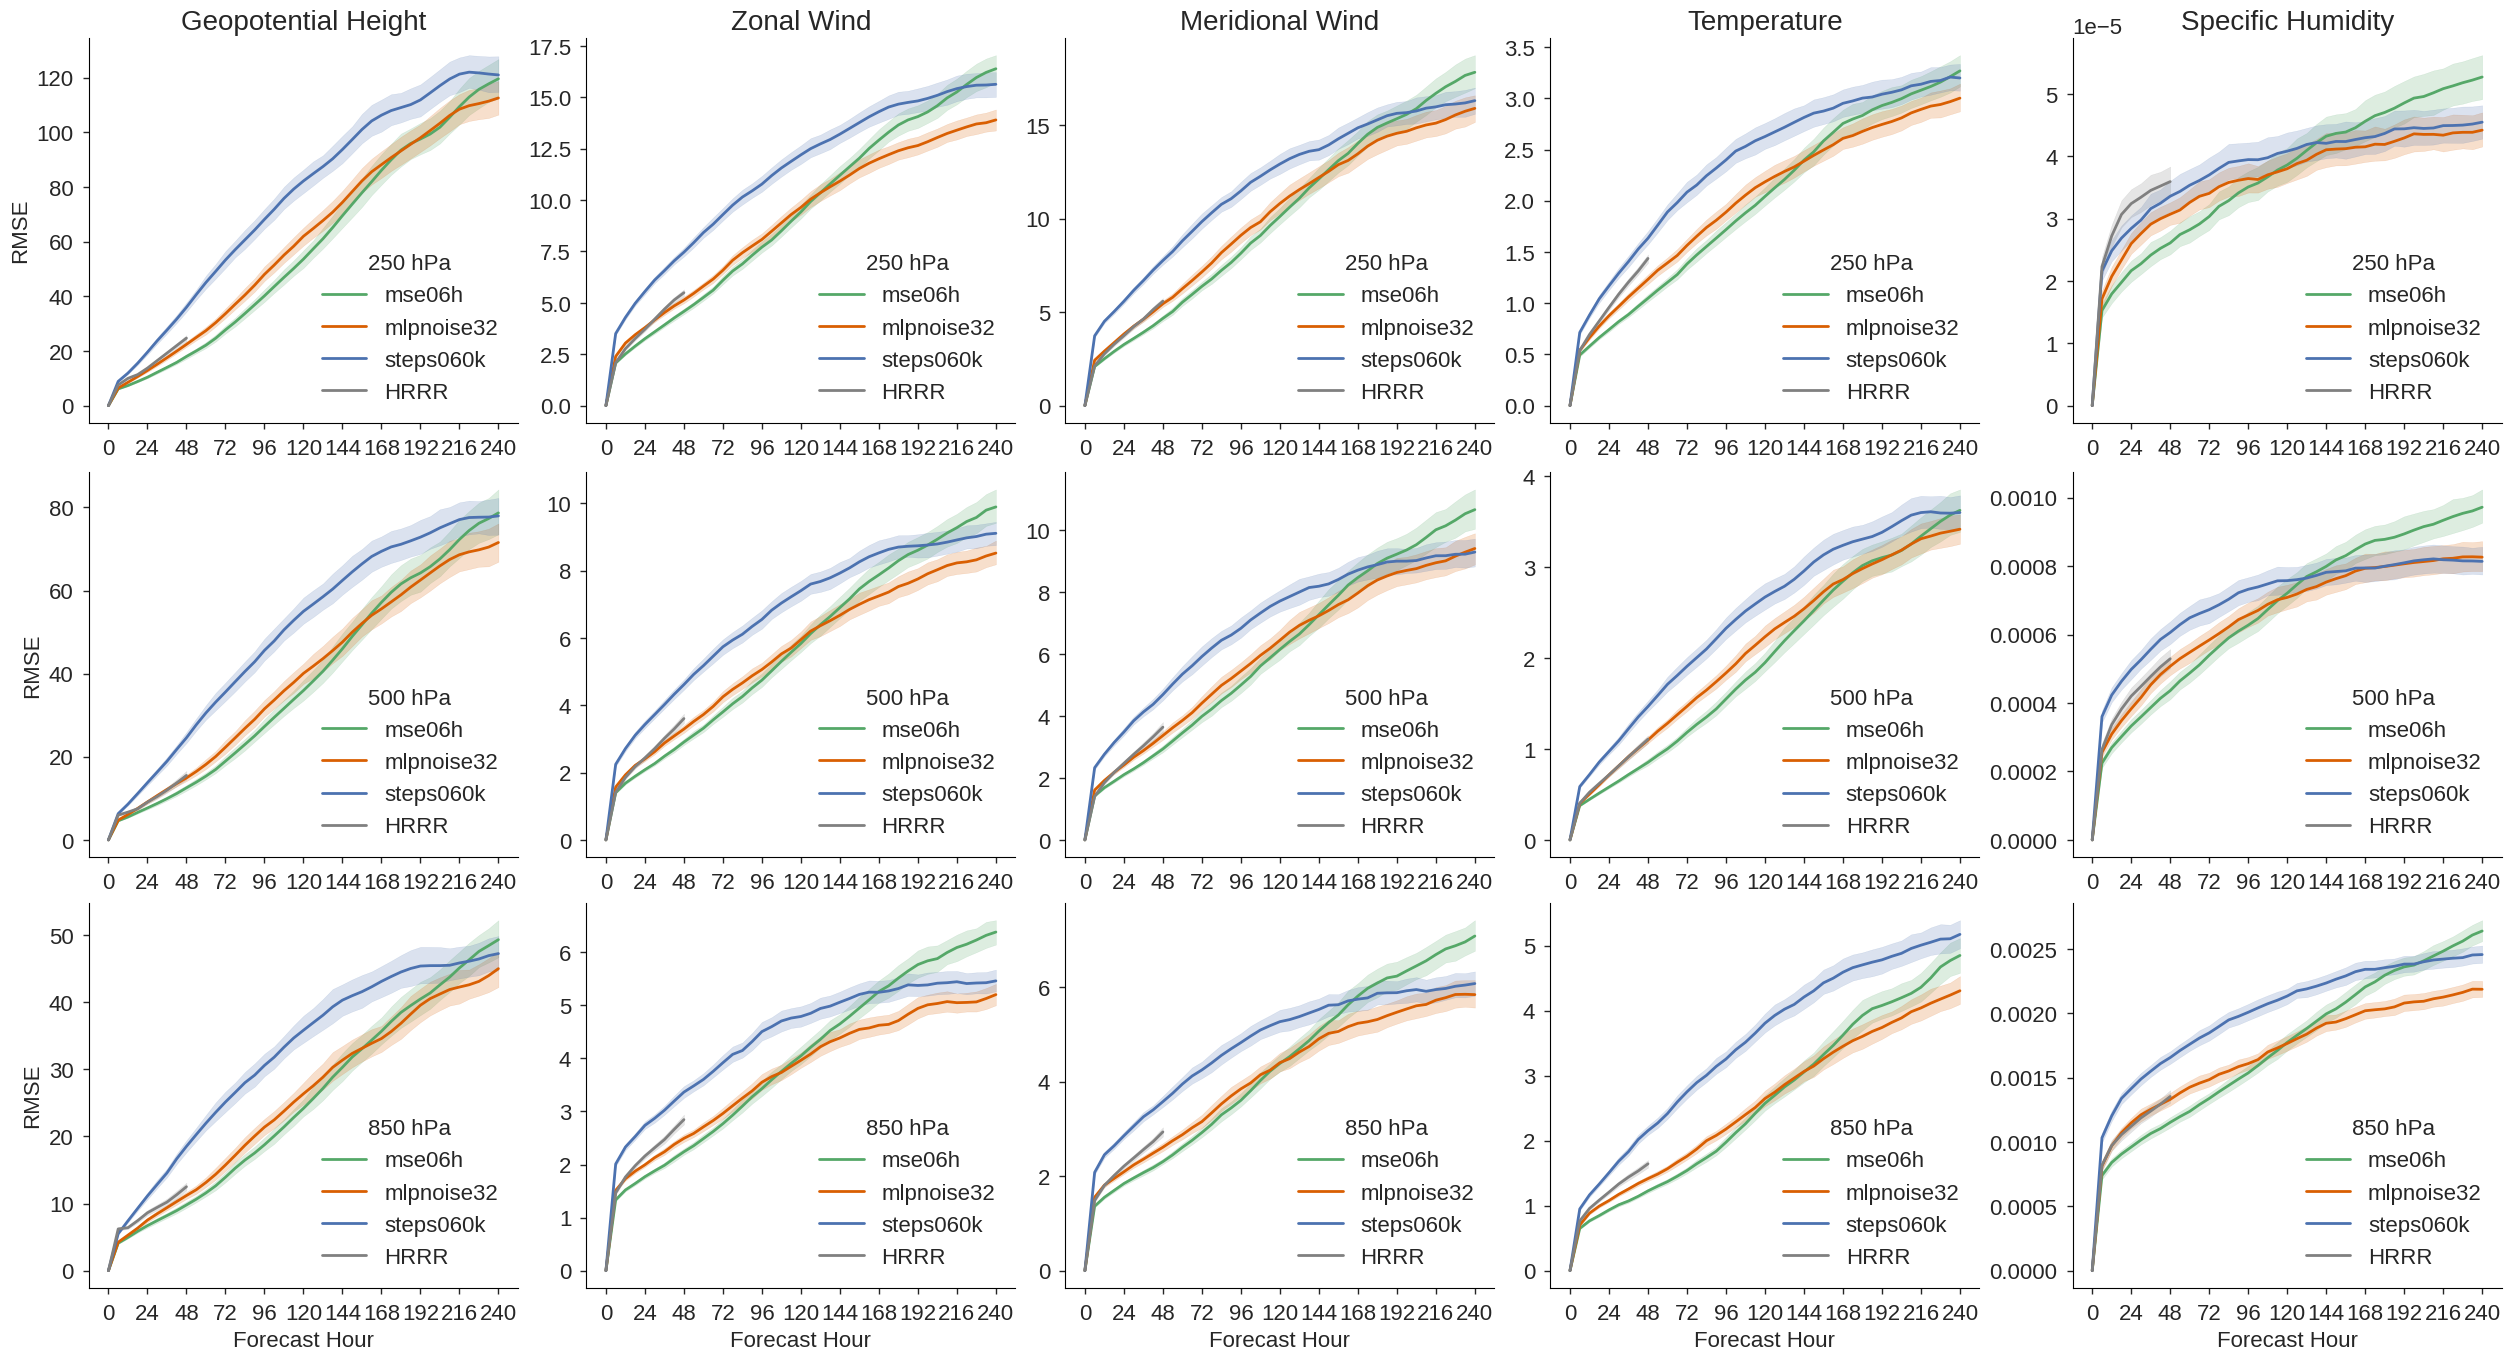

In [9]:
for name, kwargs in zip(["48h", "10d"], [{"sel": {"fhr": slice(49)}, "marker": "o"}, {}]):
    fig, axs = plot_level_vars(
        ["gh", "u", "v", "t", "q"],
        dsdict=base,
        **kwargs,
    )
    
    fname = f"figures/plevel_{metric}_vs_hrrr_analysis_{name}.jpeg"
    #fig.savefig(fname, dpi=300, bbox_inches="tight")

In [73]:
ssr =  {
    "mlpnoise32": xr.load_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/crps06h/experiments/base/mlpnoise32/inference-validation/spread.nested-lam.nc", decode_timedelta=False),
    "steps060k": xr.load_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/crps06h/experiments/training-steps/steps060k/inference-validation/spread.nested-lam.nc", decode_timedelta=False),
}

    
ssr = ssr / base["Ensemble Mean"]
ssr.loc[{"fhr": 0}] = np.nan
ssr = {
    "Ensemble Mean": ssr,#ssr.isel(fhr=slice(1,None)),
    #"factored": np.sqrt(11/10)*ssr.isel(fhr=slice(1,None)),
}


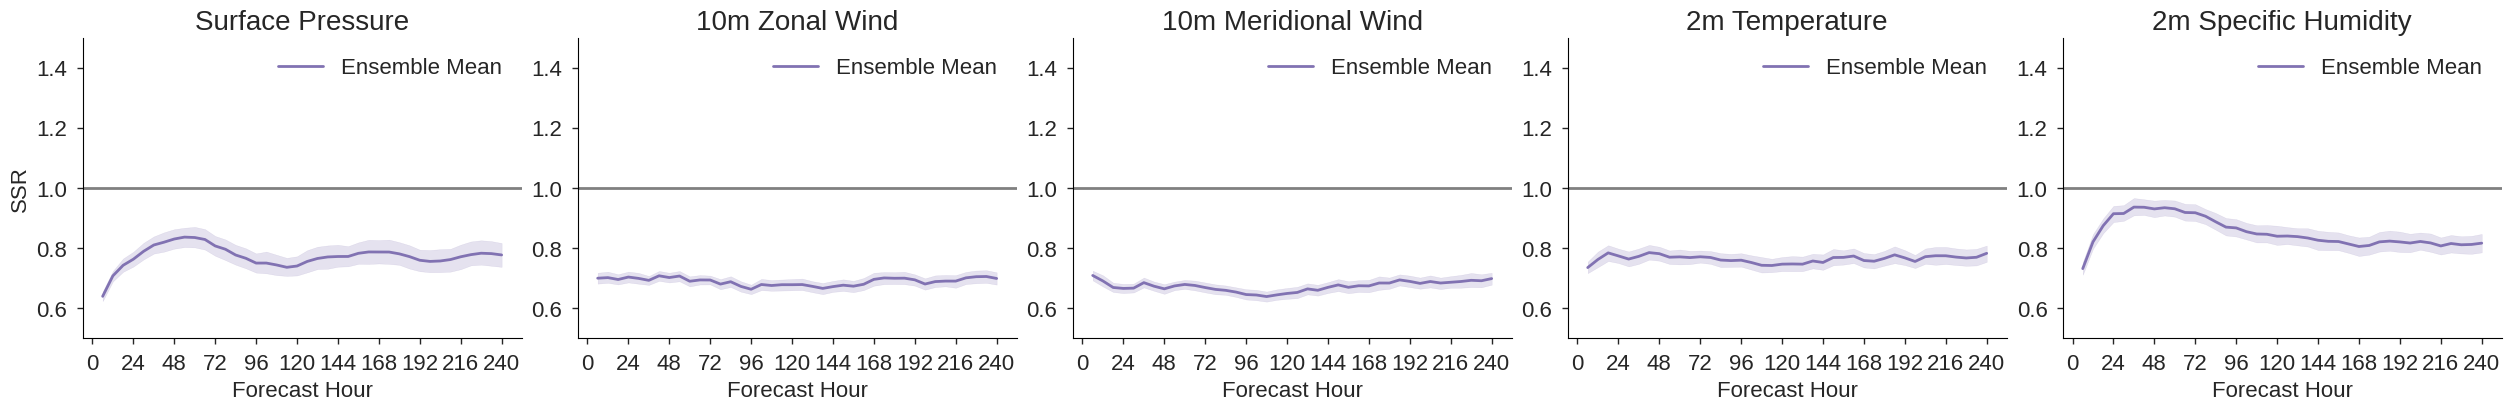

In [74]:
metric = "SSR"
fig, axs = plot_surface_error(
    ["sp", "u10", "v10", "t2m", "sh2"],
    dsdict=ssr,
)
for ax in axs:
    ax.axhline(y=1, color="gray")
    ax.set(ylim=[.5, 1.5])
    
fname = f"figures/surface_ssr_vs_hrrr_analysis_10d.jpeg"
fig.savefig(fname, dpi=300, bbox_inches="tight")

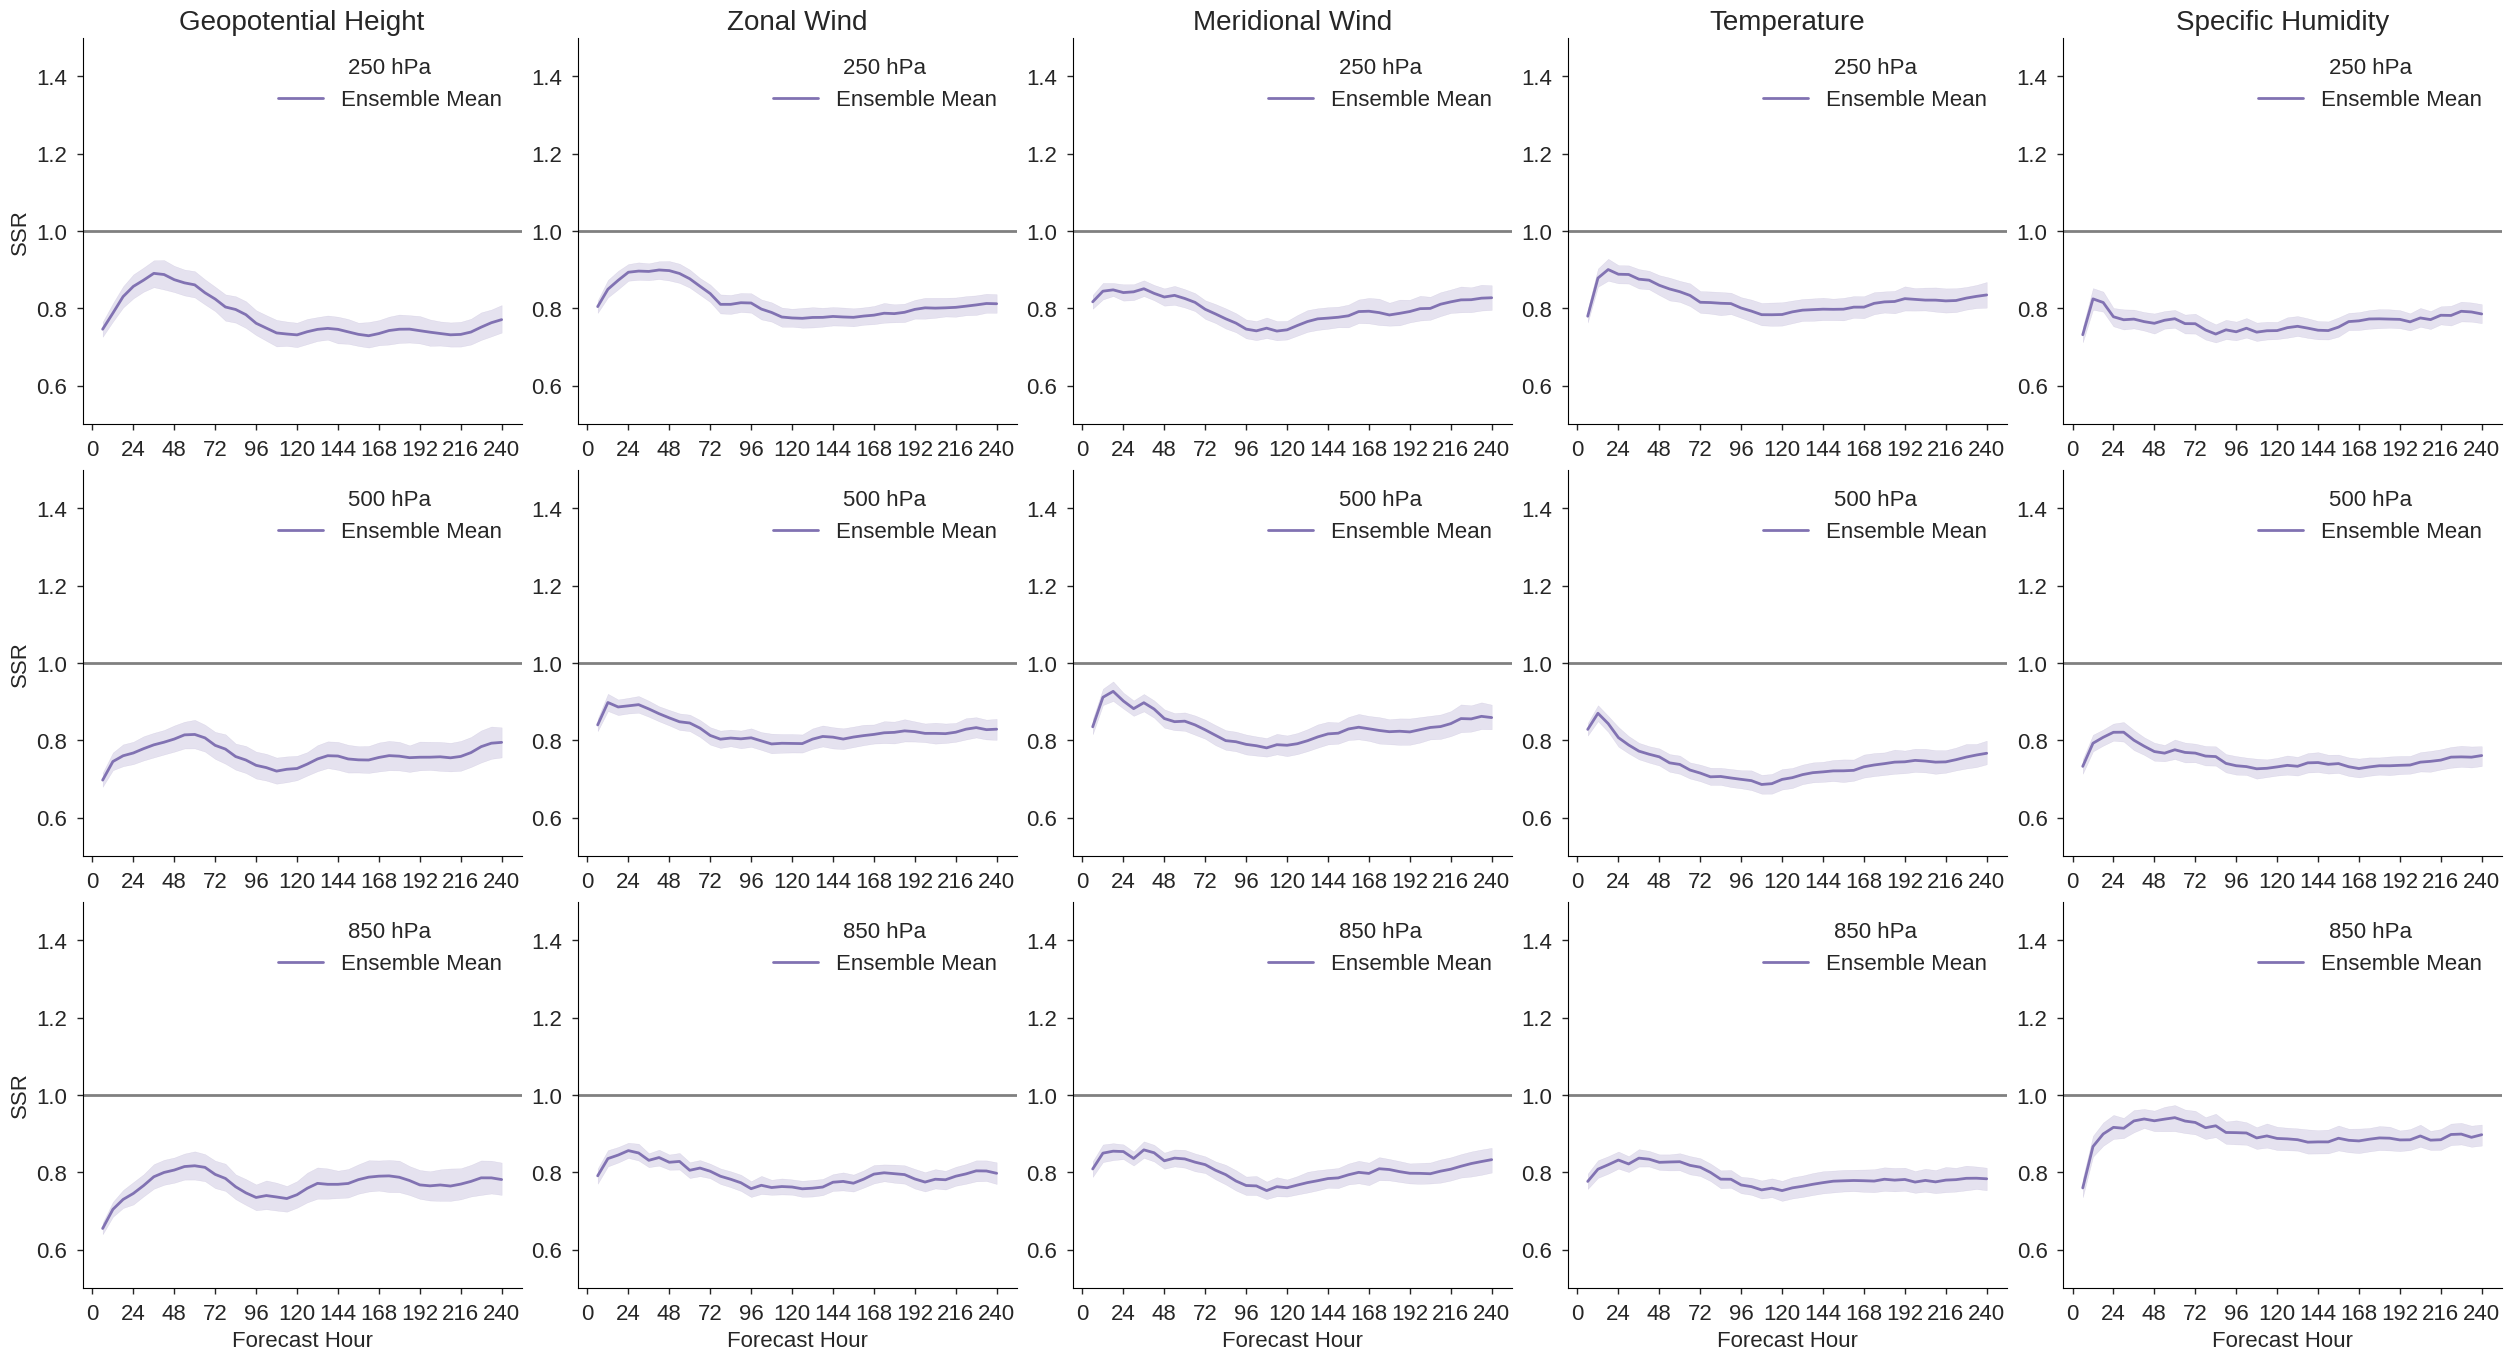

In [78]:
metric = "SSR"
fig, axs = plot_level_vars(
    ["gh", "u", "v", "t", "q"],
    dsdict=ssr,
    **kwargs,
)

for ax in axs.flatten():
    ax.axhline(y=1, color="gray")
    ax.set(ylim=[.5, 1.5])
    
fname = f"figures/plevel_ssr_vs_hrrr_analysis_10d.jpeg"
fig.savefig(fname, dpi=300, bbox_inches="tight")